In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# min-max scaler
from sklearn.preprocessing import MinMaxScaler

# recursive feature elimination
from sklearn.feature_selection import RFE

# estimators
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor

In [2]:
# read clean electricity data to create target variable array y
elec = pd.read_csv('../data/elec_clean.csv',index_col=0)
elec.index = pd.to_datetime(elec.index,format='%Y-%m-%d %H:00:00')

# remove Davenport for now because it is missing most of June and July
elec.drop('Davenport',axis=1,inplace=True)

agg = pd.DataFrame({'actual':elec.sum(axis=1)})

### Writing iterative forecasting procedure

IMPROVEMENT: define one dataframe called "features" with both lag and date features, then create a dataframe called "static_features" that only has the date features

In [ ]:
# create lag features dataframe on which to build test rows
lag_features = pd.DataFrame({'actual':elec.sum(axis=1)})
for i in [1,2,3,24,25,26,48,49,50]:
    lag_features['t-'+str(i)] = np.append(np.array([np.nan]*i),lag_features['actual'][0:len(lag_features)-i])
lag_features = lag_features['2018-01-04 00:00:00':]

# create features dataframe
features = pd.DataFrame(index=pd.date_range(start='2018-01-01', end='2019-01-01', freq='H',closed='left'))

# add day of week features
days = ['mon','tues','wed','thurs','fri','sat','sun']
for i in range(7):
    features[days[i]] = (np.array([i]*len(features))==np.asarray(features.index.dayofweek)).astype(int)
    
# add hour of day features
for i in range(12):
    features[str(i)+'am'] = (np.array([i]*len(features))==np.asarray(features.index.hour)).astype(int)
for i in range(12,24):
    features[str(i-12)+'pm'] = (np.array([i]*len(features))==np.asarray(features.index.hour)).astype(int)
features = features.rename({'0am':'12am','0pm':'12pm'},axis=1)

# feature for school breaks
features['break'] = (features.index.isin(pd.date_range(start='01/01/2018',end='01/15/2018',freq='H'))
                     |features.index.isin(pd.date_range(start='03/10/2018',end='03/25/2018',freq='H'))
                     |features.index.isin(pd.date_range(start='05/10/2018',end='08/22/2018',freq='H'))
                    ).astype(int)

# feature for office holidays: MLK day, memorial day, 4th of july
features['holiday'] = (features.index.isin(pd.date_range(start='01/15/2018',end='01/16/2018',freq='H'))
                       |features.index.isin(pd.date_range(start='05/28/2018',end='05/29/2018',freq='H'))
                       |features.index.isin(pd.date_range(start='07/04/2018',end='07/05/2018',freq='H'))
                      ).astype(int)

all_features = lag_features.join(features)
all_features.head(3)

In [4]:
# define complete versions of X, y
X = all_features.loc[:,'t-1':]
y = all_features.loc[:,'actual']

In [18]:
# model parameters
num_days = 170
start = '2018-01-10 09:00:00'
results = pd.DataFrame({'actual':elec.sum(axis=1),'forecasted':elec.sum(axis=1)})

for j in pd.date_range(start=start,freq='D',periods=num_days):
    # truncate X,y according to train/test split, scale them, and create active versions
    X_train = X[:j]
    y_train = y[:j]
    X_scaler = MinMaxScaler().fit(X.values)
    y_scaler = MinMaxScaler().fit(y.values.reshape(-1,1))
    X_train_active = X_scaler.transform(X_train.values)
    y_train_active = y_scaler.transform(y_train.values.reshape(-1,1)).ravel()

    for i in pd.date_range(start=j,freq='H',periods=39):
        # calculate updated lag features for this time step
        t1 = y_train_active[len(y_train_active)-1]
        t2 = y_train_active[len(y_train_active)-2]
        t3 = y_train_active[len(y_train_active)-3]
        t24 = y_train_active[len(y_train_active)-24]
        t25 = y_train_active[len(y_train_active)-25]
        t26 = y_train_active[len(y_train_active)-26]
        t48 = y_train_active[len(y_train_active)-48]
        t49 = y_train_active[len(y_train_active)-49]
        t50 = y_train_active[len(y_train_active)-50]

        # combine lag features and date-related features
        lags = np.array([t1,t2,t3,t24,t25,t26,t48,t49,t50]).reshape(9,)
        X_pred = np.append(lags,features.loc[i].values)

        # make prediction based on X_pred
        reg = MLPRegressor().fit(X_train_active, y_train_active)
        y_pred = reg.predict(X_pred.reshape(1, -1))

        # write results to active arrays
        X_train_active = np.append(X_train_active,X_pred.reshape(1,-1),axis=0)
        y_train_active = np.append(y_train_active,y_pred.reshape(1,))
    
    # save results of this forecast
    raw_forecast = y_train_active[len(y_train_active)-24:]
    forecast = y_scaler.inverse_transform(raw_forecast.reshape(-1,1)).ravel()
    results['forecasted'].loc[j+pd.Timedelta(hours=15):j+pd.Timedelta(hours=38)] = forecast

results = results[pd.to_datetime(start)+pd.Timedelta(hours=15):pd.to_datetime(start)+pd.Timedelta(days=num_days)]

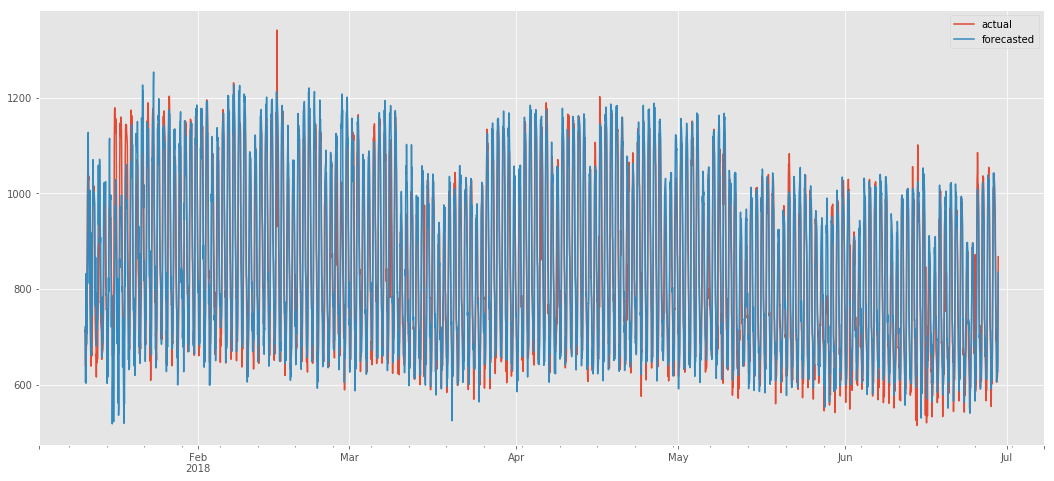

In [19]:
results.plot(figsize=(18,8))

In [20]:
def mape(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true))*100

mape(results['actual'].values,results['forecasted'].values)

4.926577382983355

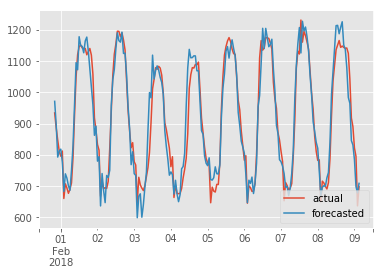